<a href="https://colab.research.google.com/github/du-hr/MNIST-CNN/blob/Teresa/MiniProject_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MiniProject 3: Multi-label Classification of Image Data


> MiniProject 3 of COMP 551 (Fall 2020) at McGill University


> Authors (G17): Haoran Du (260776911), Robin Cho (260806783), Teresa Lee (260715070)





In [ ]:
import numpy as np
import scipy as sci
import pandas as pd
import h5py
import torch
from google.colab import drive
# ignore the follwoing line if running locally
drive.mount('/content/drive')
# make path = './' if running locally
path = '/content/drive/My Drive/'

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Datasets**

### **1.1 Import Data**

<KeysViewHDF5 ['test_dataset', 'train_dataset', 'train_labels']>
(56000, 64, 64, 1)


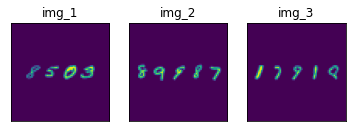

(56000, 5)
[[ 8  5  0  3 10]
 [ 8  9  9  8  7]
 [ 1  7  9  1  8]
 ...
 [ 4  4 10 10 10]
 [ 7  9  8 10 10]
 [ 6 10 10 10 10]]


In [ ]:
# load the datasets
with h5py.File(path+'MNIST_synthetic.h5', 'r') as hdfid:
     print(hdfid.keys())
     test_images = hdfid['test_dataset'][()]
     train_images = hdfid['train_dataset'][()]
     train_labels = hdfid['train_labels'][()]

# display train_images properties
print(train_images.shape)
# print(train_iamges[10][30])

# plot first 3 images in train_images
images=[]
titles=[]
images.append(np.array(train_images[0], dtype='float').reshape(64,64))
titles.append("img_1")
images.append(np.array(train_images[1], dtype='float').reshape(64,64))
titles.append("img_2")
images.append(np.array(train_images[2], dtype='float').reshape(64,64))
titles.append("img_3")

for i in range(3):
    plt.subplot(1,3,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

# display train_labels properties
print(train_labels.shape)
print(train_labels)

### **1.2 Data Preprocessing**

###**1.2.1 One Hot Encoding**

In [ ]:
#First, perform OHE on training labels
from keras.utils import to_categorical

train_new_labels = to_categorical(train_labels)
Y_train = torch.from_numpy(train_new_labels) #save the oneHotEncoded labels as tensor

In [ ]:
Y_train

tensor([[[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0.,

In [ ]:
'''
category = np.array(range(0,11))
category_list = list()
for i in list(range(0,5)):
  category_list.append(category)

oneHot = preprocessing.OneHotEncoder(categories=category_list)
oneHot.fit(train_labels)
train_new_labels = oneHot.transform(train_labels).toarray()
'''

(56000, 55)

### **1.2.2 Data Normalization**

In [ ]:
# normalize to range 0-1 with typecast to float
scaled_train_images = train_images.astype('float32') / 255.0
scaled_test_images = test_images.astype('float32') / 255.0

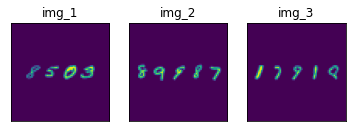

In [ ]:
images_scaled=[]
titles_scaled=[]
images_scaled.append(np.array(scaled_train_images[0], dtype='float').reshape(64,64))
titles_scaled.append("img_1")
images_scaled.append(np.array(scaled_train_images[1], dtype='float').reshape(64,64))
titles_scaled.append("img_2")
images_scaled.append(np.array(scaled_train_images[2], dtype='float').reshape(64,64))
titles_scaled.append("img_3")

for i in range(3):
    plt.subplot(1,3,i+1),plt.imshow(images_scaled[i])
    plt.title(titles_scaled[i])
    plt.xticks([]),plt.yticks([])

plt.show()

In [ ]:
X_train = torch.from_numpy(scaled_train_images)
X_test = torch.from_numpy(scaled_test_images)

### **1.2.3 Class Distribution**


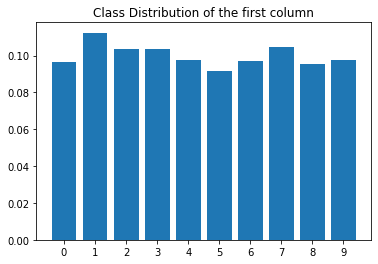

In [ ]:
unique_y1, counts_y1 = np.unique(train_labels[:, 0], return_counts=True)
plt.bar(unique_y1, counts_y1/sum(counts_y1))
plt.xticks(unique_y1, unique_y1)
plt.title(f"Class Distribution of the first column")
plt.show()

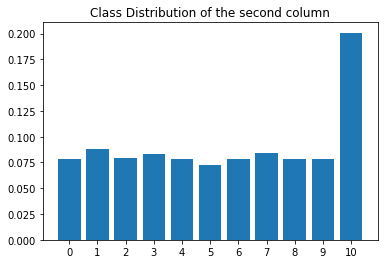

In [ ]:
unique_y2, counts_y2 = np.unique(train_labels[:, 1], return_counts=True)
plt.bar(unique_y2, counts_y2/sum(counts_y2))
plt.xticks(unique_y2, unique_y2)
plt.title(f"Class Distribution of the second column")
plt.show()

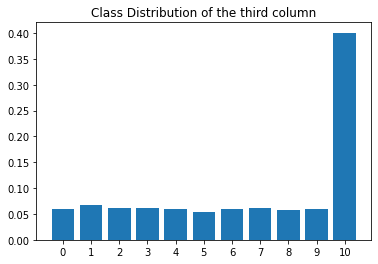

In [ ]:
unique_y3, counts_y3 = np.unique(train_labels[:, 2], return_counts=True)
plt.bar(unique_y3, counts_y3/sum(counts_y3))
plt.xticks(unique_y3, unique_y3)
plt.title(f"Class Distribution of the third column")
plt.show()

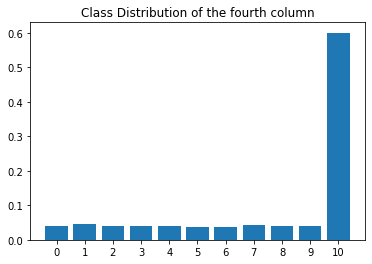

In [ ]:
unique_y4, counts_y4 = np.unique(train_labels[:, 3], return_counts=True)
plt.bar(unique_y4, counts_y4/sum(counts_y4))
plt.xticks(unique_y4, unique_y4)
plt.title(f"Class Distribution of the fourth column")
plt.show()

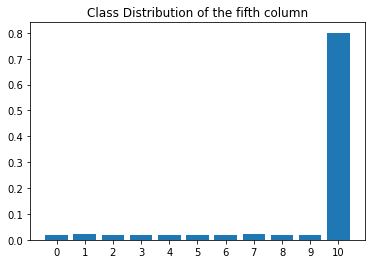

In [ ]:
unique_y5, counts_y5 = np.unique(train_labels[:, 4], return_counts=True)
plt.bar(unique_y5, counts_y5/sum(counts_y5))
plt.xticks(unique_y5, unique_y5)
plt.title(f"Class Distribution of the fifth column")
plt.show()

### **1.2.4 Upper bound and lower bound of the images**
Note: the name of the title is subject to change


In [ ]:
def lowerBound(x):
  N = x.shape[1]
  D = x.shape[0]
  lowerBounds = [0]*D
  bound = x[0, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, j], bound)):
        lowerBounds[i] = j + 1
      else:
        break
  return min(lowerBounds)
  
def upperBound(x):
  N = x.shape[1]
  D = x.shape[0]
  upperBounds = [64]*D
  bound = x[0, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, 63-j], bound)):
        upperBounds[i] = 63-j
      else:
        break
  return max(upperBounds)

In [ ]:
'''
def leftBound(x):
  N = x.shape[2]
  D = x.shape[0]
  lowerBounds = [0]*D
  bound = x[0, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, j], bound)):
        lowerBounds[i] = j + 1
      else:
        break
  return max(lowerBounds)
  
def rightBound(x):
  N = x.shape[2]
  D = x.shape[0]
  upperBounds = [64]*D
  bound = x[0, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, 63-j], bound)):
        upperBounds[i] = 63-j
      else:
        break
  return min(upperBounds)

In [ ]:
u = upperBound(X_train)
u

38

In [ ]:
l = lowerBound(X_train)
l

26

## **2. Neural Network Models**

## **3. Performance**